# Models 

- only evening
- only SVM linear

In [2]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [5]:
meta = {}
meta[38] = {'mouse':'3C280', 'ks':'Kilosort_2024-03-27_150459', 'del_units':[936,1005,1043,1135,1137,1138,1140], 'vis_mice':np.array(['nan', 'alpha1', 'beta1','nan', 'alpha2', 'beta2']), 'active_blocks':[1,2,4,5]}
meta[43] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_142858', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha1', 'beta1','nan', 'alpha2', 'beta2']), 'active_blocks':[1,2,4,5]}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta1', 'alpha1','blank','nan', 'beta2', 'alpha2']),'active_blocks':[1,2,3,5,6]}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan','alpha1', 'beta1','blank','nan','alpha2', 'beta2']), 'active_blocks':[1,2,3,5,6]}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835], 'vis_mice':np.array(['nan', 'beta1', 'alpha1','blank','nan', 'beta2', 'alpha2']),'active_blocks':[1,2,3,5,6]}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta1', 'alpha1','blank','nan', 'beta2', 'alpha2']),'active_blocks':[1,2,3,5,6]}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta1', 'alpha1','blank','nan', 'beta2', 'alpha2']),'active_blocks':[1,2,3,5,6]}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta1', 'alpha1','blank','nan', 'beta2', 'alpha2']),'active_blocks':[1,2,3,5,6]}


In [6]:
Session = 11

In [7]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = meta[Session]['active_blocks']

In [25]:
a1_idx = np.where(vis_mice=='alpha1')[0][0]
b1_idx = np.where(vis_mice=='beta1')[0][0]
a2_idx = np.where(vis_mice=='alpha2')[0][0]
b2_idx = np.where(vis_mice=='beta2')[0][0]

In [8]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening')
except:
    pass

In [9]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\S{Session}')
except:
    pass

### Ephys data

In [10]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [11]:
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = []
for clust in goodclusts :
    goods.append(clust)
print(f'Session {Session}: {len(goods)} good clusters')

Session 11: 40 good clusters


In [12]:
goodspiketimes = {}

spikethresh = 1000 # min nb of spikes
for goodunit in goods :
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : 
        goodspiketimes[goodunit] = spiketimes[goodinds]

In [13]:
len(goodspiketimes.keys())

38

### Behavior data

In [14]:
matfile =  f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [15]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [16]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12)

## Data prep: firing rate array

In [17]:
import copy

In [18]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic
        

### Firing rates

firing rate [Hz] = spike_count/ time_window(sec)

* lets find it for each trial for each cell
* we will make an array where each row is trial; each column - neuron; we will collect it in dict where keys = blocks

In [19]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s

binsize = 0.25*samplplimg_rate 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [20]:
# 250 ms during the nosepoke
fr_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=active_blocks, bins=bins, del_units=del_units)

In [21]:
fr_dic.keys()

dict_keys([1, 2, 3, 5, 6])

In [22]:
fr_dic[1].shape

(30, 36)

## PCA just for fan

In [23]:
from scipy.stats import multivariate_normal
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [27]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [26]:
n_clusters=4
firing_rates_concat = np.concatenate((fr_dic[a1_idx], fr_dic[b1_idx], fr_dic[a2_idx], fr_dic[b2_idx]),axis=0)

In [28]:
# Standardize the data
scaler = StandardScaler() # z-scoring (x-mean)/sd
scaled_data = scaler.fit_transform(firing_rates_concat)

# Apply PCA
pca = PCA(n_components=2)  # Choose number of components based on explained variance
principal_components = pca.fit_transform(scaled_data)

# Scale each principal component to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
principal_components = scaler.fit_transform(principal_components)  

In [29]:
k12 = fr_dic[a1_idx].shape[0]
k34 = fr_dic[a2_idx].shape[0]

a1_pca = principal_components[:k12,:]
b1_pca = principal_components[k12:k12*2,:]
a2_pca = principal_components[k12*2:k12*2+k34,:]
b2_pca = principal_components[k12*2+k34:,:]

centroid_a1_pca = np.median(a1_pca, axis=0).reshape(1, -1)[0]
centroid_b1_pca = np.median(b1_pca, axis=0).reshape(1, -1)[0]
centroid_a2_pca = np.median(a2_pca, axis=0).reshape(1, -1)[0]
centroid_b2_pca = np.median(b2_pca, axis=0).reshape(1, -1)[0]

a1_pca.shape, b1_pca.shape, a2_pca.shape, b2_pca.shape, centroid_a1_pca.shape

((30, 2), (30, 2), (10, 2), (10, 2), (2,))

In [30]:
def fit_gaussian(data):
    """Fit a 2D Gaussian to the data and return the mean and covariance."""
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def plot_ellipse(mean, cov, ax, n_std=1.0, color='red', **kwargs):
    """Plot an ellipse representing the Gaussian mean ± n_std * standard deviations."""
    # Eigenvalue decomposition to find the axis lengths and rotation angle
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Width and height are "full" lengths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    
    ell = patches.Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=None, facecolor=color, alpha=0.35, **kwargs)
    ax.add_patch(ell)

In [31]:
# Create custom colormaps
def create_custom_cmap(base_cmap):
    colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade
    return LinearSegmentedColormap.from_list(f'{base_cmap}_custom', colors)


C:\Users\ebukina\AppData\Local\Temp\ipykernel_7740\2465973930.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade


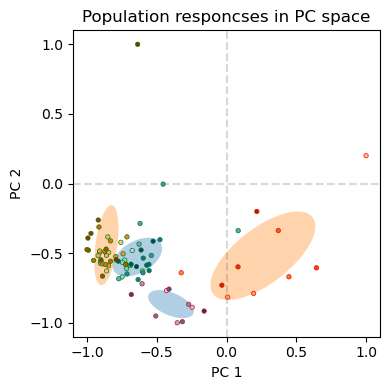

In [32]:
data_pca = [a1_pca, b1_pca, a2_pca, b2_pca]
colors = ['#1F77B4', '#FF8113', '#1F77B4', '#FF8113']
names = ['alpha1', 'beta1', 'alpha2', 'beta2']
base_colormaps = ['Blues', 'Oranges', 'Blues', 'Oranges']
edgecolors = ['green', 'green', 'red', 'red']
custom_colormaps = [create_custom_cmap(cmap) for cmap in base_colormaps]

fig, ax = plt.subplots(figsize=(4, 4))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1


i = 0
# Plot the data points with gradient colors for each cluster
for data, cmap, edgecolor in zip(data_pca, custom_colormaps, edgecolors):
    norm = Normalize(vmin=0, vmax=len(data))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colors = sm.to_rgba(range(len(data)))
    
    # Plot data points with gradient color
    ax.scatter(data[:, 0], data[:, 1], s=10, color=colors, edgecolor=edgecolor, linewidth=0.5)
    i = 0


plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
# plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_pca.png', dpi=300, bbox_inches='tight')
plt.show() 

C:\Users\ebukina\AppData\Local\Temp\ipykernel_7740\2465973930.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade


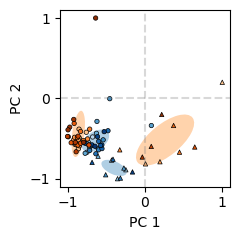

In [35]:
data_pca = [a1_pca, b1_pca, a2_pca, b2_pca]
colors = ['#1F77B4', '#FF8113', '#1F77B4', '#FF8113']
names = ['alpha1', 'beta1', 'alpha2', 'beta2']
base_colormaps = ['Blues', 'Oranges', 'Blues', 'Oranges']
# edgecolors = ['green', 'green', 'red', 'red']
markers = ['o','o','^','^']
custom_colormaps = [create_custom_cmap(cmap) for cmap in base_colormaps]

fig, ax = plt.subplots(figsize=(2.5,2.5))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1


i = 0
# Plot the data points with gradient colors for each cluster
for data, cmap, marker in zip(data_pca, custom_colormaps, markers):
    norm = Normalize(vmin=0, vmax=len(data))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colors = sm.to_rgba(range(len(data)))
    
    # Plot data points with gradient color
    ax.scatter(data[:, 0], data[:, 1], s=10, color=colors, edgecolor='k', marker = marker, linewidth=0.5)
    i = 0

plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_pca_mini.png', dpi=300, bbox_inches='tight')
plt.show() 

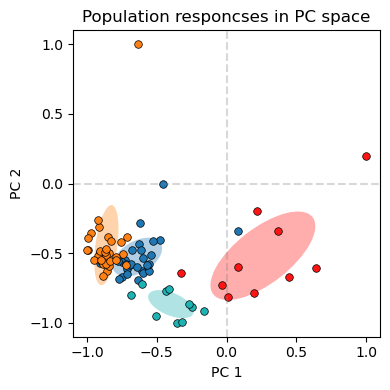

In [26]:
# data_pca = [a1_pca, b1_pca, a2_pca, b2_pca]
# colors = ['#1F77B4', '#FF8113', '#1eb3b3', '#ff1414']
# names = ['alpha1', 'beta1', 'alpha2', 'beta2']

# fig, ax = plt.subplots(figsize=(4, 4))

# i = 0
# for data, color in zip(data_pca, colors):
#     mean, cov = fit_gaussian(data)
#     plot_ellipse(mean, cov, ax, color=color)
#     i+=1

# i = 0
# for data, color in zip(data_pca, colors):
#     # Plot data points
#     ax.scatter(data[:, 0], data[:, 1], s=30, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
#     i+=1

# plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# # plt.grid(True)
# # plt.axis('equal')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# # plt.ylim(-1,1)
# # plt.xlim(-1,1)
# plt.xticks([-1, -0.5, 0, 0.5, 1])
# plt.yticks([-1, -0.5, 0, 0.5, 1])
# plt.title('Population responcses in PC space')
# # plt.legend()
# plt.tight_layout()
# plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_pca.png', dpi=300, bbox_inches='tight')
# plt.show() 

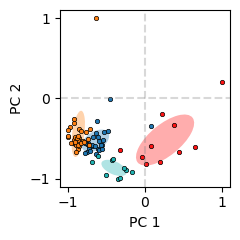

In [27]:
# data_pca = [a1_pca, b1_pca, a2_pca, b2_pca]
# colors = ['#1F77B4', '#FF8113', '#1eb3b3', '#ff1414']
# names = ['alpha1', 'beta1', 'alpha2', 'beta2']

# fig, ax = plt.subplots(figsize=(2.5,2.5))

# i = 0
# for data, color in zip(data_pca, colors):
#     mean, cov = fit_gaussian(data)
#     plot_ellipse(mean, cov, ax, color=color)
#     i+=1

# i = 0
# for data, color in zip(data_pca, colors):
#     # Plot data points
#     ax.scatter(data[:, 0], data[:, 1], s=10, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
#     i+=1

# plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# # plt.grid(True)
# # plt.axis('equal')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# # plt.ylim(-1,1)
# # plt.xlim(-1,1)
# plt.xticks([-1, 0, 1])
# plt.yticks([-1, 0, 1])
# # plt.title('Population responcses in PC space')
# # plt.legend()
# plt.tight_layout()
# plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_pca_mini.png', dpi=300, bbox_inches='tight')
# plt.show() 

In [36]:
from scipy.spatial.distance import mahalanobis
import scipy.stats as stats
from scipy.stats import percentileofscore
import seaborn as sns
import math

def euclidean(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [37]:
covar = np.cov(principal_components.T)
covarinv = np.linalg.inv(covar)

# sparsity
D_aa = [mahalanobis(x, centroid_a1_pca, covarinv) for x in a1_pca]
D_ab = [mahalanobis(x, centroid_a1_pca, covarinv) for x in b1_pca]
D_ac = [mahalanobis(x, centroid_a1_pca, covarinv) for x in a2_pca]
D_ad = [mahalanobis(x, centroid_a1_pca, covarinv) for x in b2_pca]

D_ba = [mahalanobis(x, centroid_b1_pca, covarinv) for x in a1_pca]
D_bb = [mahalanobis(x, centroid_b1_pca, covarinv) for x in b1_pca]
D_bc = [mahalanobis(x, centroid_b1_pca, covarinv) for x in a2_pca]
D_bd = [mahalanobis(x, centroid_b1_pca, covarinv) for x in b2_pca]

D_ca = [mahalanobis(x, centroid_a2_pca, covarinv) for x in a1_pca]
D_cb = [mahalanobis(x, centroid_a2_pca, covarinv) for x in b1_pca]
D_cc = [mahalanobis(x, centroid_a2_pca, covarinv) for x in a2_pca]
D_cd = [mahalanobis(x, centroid_a2_pca, covarinv) for x in b2_pca]

D_da = [mahalanobis(x, centroid_b2_pca, covarinv) for x in a1_pca]
D_db = [mahalanobis(x, centroid_b2_pca, covarinv) for x in b1_pca]
D_dc = [mahalanobis(x, centroid_b2_pca, covarinv) for x in a2_pca]
D_dd = [mahalanobis(x, centroid_b2_pca, covarinv) for x in b2_pca]




# assemble matrix
D_matrix = np.zeros((4,4))
D_matrix[0,0] = np.median(D_aa)
D_matrix[0,1] = np.median(D_ab)
D_matrix[0,2] = np.median(D_ac)
D_matrix[0,3] = np.median(D_ad)

D_matrix[1,0] = np.median(D_ba)
D_matrix[1,1] = np.median(D_bb)
D_matrix[1,2] = np.median(D_bc)
D_matrix[1,3] = np.median(D_bd)

D_matrix[2,0] = np.median(D_ca)
D_matrix[2,1] = np.median(D_cb)
D_matrix[2,2] = np.median(D_cc)
D_matrix[2,3] = np.median(D_cd)

D_matrix[3,0] = np.median(D_da)
D_matrix[3,1] = np.median(D_db)
D_matrix[3,2] = np.median(D_dc)
D_matrix[3,3] = np.median(D_dd)


In [38]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_D_matrix.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(D_matrix, f)

In [39]:
import seaborn as sns

In [47]:
def plot_distance_matrix(D_matrix, D_type = "MD", rotate=False):
    plt.figure(figsize=(4, 2.5))

    labels = ['Alpha1', 'Beta1', 'Alpha2', 'Beta2']

    if D_type=='MD':
        cbar_label = 'Mahalanobis distance'
    else:
        cbar_label = 'Euclidean distance'

    if rotate:
        # Create the heatmap
        heatmap = sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        heatmap.set_xticklabels(labels, rotation=0)
        heatmap.set_yticklabels(labels, rotation=90)

        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(rotation=90)

    else:
        # Create the heatmap
        sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=0)
        plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=90)

    plt.title('Distance in PC space\n')
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_{D_type}_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

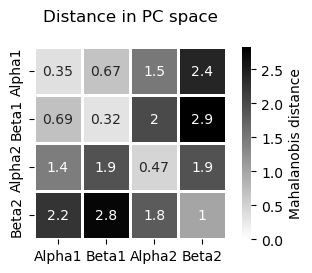

In [48]:
plot_distance_matrix(D_matrix)

In [42]:
# distance bw centroids
D_ab_x = mahalanobis(centroid_a1_pca, centroid_b1_pca, covarinv)
D_ac_x = mahalanobis(centroid_a1_pca, centroid_a2_pca, covarinv)
D_ad_x = mahalanobis(centroid_a1_pca, centroid_b2_pca, covarinv)
D_bc_x = mahalanobis(centroid_b1_pca, centroid_a1_pca, covarinv)
D_bd_x = mahalanobis(centroid_b1_pca, centroid_b2_pca, covarinv)
D_cd_x = mahalanobis(centroid_a2_pca, centroid_b2_pca, covarinv)

In [43]:
MD_x = [D_ab_x,D_ac_x,D_ad_x,D_bc_x,D_bd_x,D_cd_x]

In [44]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_MD_centroids.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(MD_x, f)

In [53]:
ED_aa = [euclidean(x, centroid_a1_pca) for x in a1_pca]
ED_ab = [euclidean(x, centroid_a1_pca) for x in b1_pca]
ED_ac = [euclidean(x, centroid_a1_pca) for x in a2_pca]
ED_ad = [euclidean(x, centroid_a1_pca) for x in b2_pca]

ED_ba = [euclidean(x, centroid_b1_pca) for x in a1_pca]
ED_bb = [euclidean(x, centroid_b1_pca) for x in b1_pca]
ED_bc = [euclidean(x, centroid_b1_pca) for x in a2_pca]
ED_bd = [euclidean(x, centroid_b1_pca) for x in b2_pca]

ED_ca = [euclidean(x, centroid_a2_pca) for x in a1_pca]
ED_cb = [euclidean(x, centroid_a2_pca) for x in b1_pca]
ED_cc = [euclidean(x, centroid_a2_pca) for x in a2_pca]
ED_cd = [euclidean(x, centroid_a2_pca) for x in b2_pca]

ED_da = [euclidean(x, centroid_b2_pca) for x in a1_pca]
ED_db = [euclidean(x, centroid_b2_pca) for x in b1_pca]
ED_dc = [euclidean(x, centroid_b2_pca) for x in a2_pca]
ED_dd = [euclidean(x, centroid_b2_pca) for x in b2_pca]




# assemble matrix
ED_matrix = np.zeros((4,4))
ED_matrix[0,0] = np.median(ED_aa)
ED_matrix[0,1] = np.median(ED_ab)
ED_matrix[0,2] = np.median(ED_ac)
ED_matrix[0,3] = np.median(ED_ad)

ED_matrix[1,0] = np.median(ED_ba)
ED_matrix[1,1] = np.median(ED_bb)
ED_matrix[1,2] = np.median(ED_bc)
ED_matrix[1,3] = np.median(ED_bd)

ED_matrix[2,0] = np.median(ED_ca)
ED_matrix[2,1] = np.median(ED_cb)
ED_matrix[2,2] = np.median(ED_cc)
ED_matrix[2,3] = np.median(ED_cd)

ED_matrix[3,0] = np.median(ED_da)
ED_matrix[3,1] = np.median(ED_db)
ED_matrix[3,2] = np.median(ED_dc)
ED_matrix[3,3] = np.median(ED_dd)

In [54]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_ED_matrix.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(ED_matrix, f)

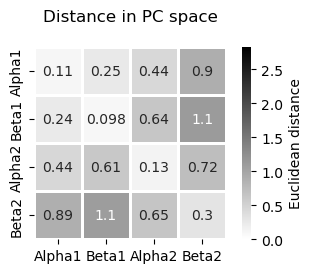

In [55]:
plot_distance_matrix(ED_matrix, D_type = "ED", rotate=False)

## Classifiers

In [58]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import percentileofscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [57]:
# data prep

alpha1_data = fr_dic[a1_idx]
beta1_data = fr_dic[b1_idx]
alpha2_data = fr_dic[a2_idx]
beta2_data = fr_dic[b2_idx]

num_rows = alpha1_data.shape[0]
shuffled_indices = list(range(num_rows))

random.shuffle(shuffled_indices)
alpha1_data = alpha1_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta1_data = beta1_data[shuffled_indices]

num_rows = alpha2_data.shape[0]
shuffled_indices = list(range(num_rows))

random.shuffle(shuffled_indices)
alpha2_data = alpha2_data[shuffled_indices]
random.shuffle(shuffled_indices)
beta2_data = beta2_data[shuffled_indices]

alpha1_data.shape, beta1_data.shape, alpha2_data.shape, beta2_data.shape

((30, 36), (30, 36), (10, 36), (10, 36))

In [59]:
# SVC linear
def SVM_evening(alpha1_data, beta1_data, alpha2_data, beta2_data):
    
    train_ab = np.concatenate((alpha1_data,beta1_data), axis=0)
    test_ab = np.concatenate((alpha2_data,beta2_data), axis=0)

    # Standardize the data
    scaler = StandardScaler()
    train_ab = scaler.fit_transform(train_ab)
    test_ab = scaler.fit_transform(test_ab)

    y_train = np.concatenate((np.ones(alpha1_data.shape[0]),np.zeros(beta1_data.shape[0])))
    y_test = np.concatenate((np.ones(alpha2_data.shape[0]),np.zeros(beta2_data.shape[0])))

    # randomize train
    num_rows = train_ab.shape[0]
    shuffled_indices = list(range(num_rows))
    random.shuffle(shuffled_indices)
    train_ab = train_ab[shuffled_indices]
    y_train = y_train[shuffled_indices]

    svm_classifier_cv = SVC(kernel='linear', random_state=666)
    svm_classifier_cv.fit(train_ab, y_train)
    y_pred = svm_classifier_cv.predict(test_ab)
    accuracy_svm = accuracy_score(y_test, y_pred)

    return accuracy_svm

In [60]:
accuracy_svm = SVM_evening(alpha1_data,beta1_data,alpha2_data,beta2_data)
accuracy_svm

0.4

In [61]:
acc_sh = []
# shuffle trials
shuffled_indices = list(range((alpha1_data.shape[0]+alpha2_data.shape[0])*2))
for sh in range(1000):
    # data prep
    data_aabb = np.concatenate((alpha1_data,beta1_data,alpha2_data,beta2_data), axis=0)
    random.shuffle(shuffled_indices)
    data_aabb = data_aabb[shuffled_indices]
    k = alpha1_data.shape[0]
    h = alpha2_data.shape[0]
    a1_sh = data_aabb[:k]
    b1_sh = data_aabb[k:k*2]
    a2_sh = data_aabb[k*2:k*2+h]
    b2_sh = data_aabb[k*2+h:]
    
    
    acc_sh.append(SVM_evening(a1_sh, b1_sh, a2_sh, b2_sh))
    

In [62]:
acc_sh_sorted = np.sort(np.array(acc_sh))
percentile_rank = percentileofscore(acc_sh_sorted, accuracy_svm)
# one-tailored
p_value_ab = 1-(percentile_rank/100)
p_value_ab

0.8055

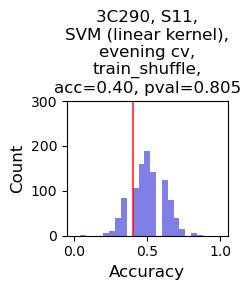

In [63]:
plt.figure(figsize=(2.5,3))  
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh, bins=bin_edges, alpha=0.5, color='#0000CD')
plt.axvline(accuracy_svm,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0.0,0.5,1.0]) 
plt.ylim(0,300)
plt.title(f'{mouse}, S{Session},\nSVM (linear kernel),\nevening cv,\ntrain_shuffle,\nacc={accuracy_svm:.2f}, pval={p_value_ab:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_SVM_ab.png', dpi=300, bbox_inches='tight')
plt.show()

morning control

In [64]:
def SVMm(alpha_data, beta_data, kernel = 'linear', cv=5):

    # random.seed(666)
    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = 6 # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [65]:
acc_svm_m = SVMm(alpha1_data, beta1_data)
acc_svm_m

0.95

In [66]:
acc_sh_m = []
# shuffle trials
# random.seed(666)
shuffled_indices = list(range(len(alpha1_data)*2))
for sh in range(1000):
    # data prep
    data_ab = np.concatenate((alpha1_data,beta1_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_ab = data_ab[shuffled_indices]
    k = alpha1_data.shape[0]
    a_sh = data_ab[:k]
    b_sh = data_ab[k:]
    
    acc_sh_m.append(SVMm(a_sh, b_sh))

In [67]:
acc_sh_m_sorted = np.sort(np.array(acc_sh_m))
percentile_rank = percentileofscore(acc_sh_m_sorted, np.mean(acc_svm_m))
# one-tailored
p_value_m = 1-(percentile_rank/100)

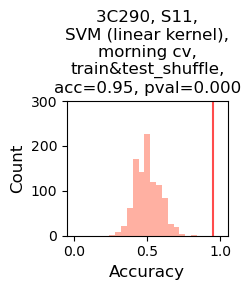

In [68]:
plt.figure(figsize=(2.5,3))  
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_m, bins=bin_edges, alpha=0.5, color='#FF6347')
plt.axvline(acc_svm_m,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0.0,0.5,1.0])  
plt.ylim(0,300)
plt.title(f'{mouse}, S{Session},\nSVM (linear kernel),\nmorning cv,\ntrain&test_shuffle,\nacc={acc_svm_m:.2f}, pval={p_value_m:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_SVM_m.png', dpi=300, bbox_inches='tight')
plt.show()

mornin vs evening decoding

In [71]:
n_trials = alpha1_data.shape[0]
trials_idx = np.arange(0,n_trials,1)
take_idx = random.sample(list(trials_idx), k=alpha2_data.shape[0])
take_idx

[11, 26, 16, 27, 0, 18, 29, 25, 1, 15]

In [72]:
ab1_data = np.concatenate((alpha1_data[take_idx],beta1_data[take_idx]), axis=0)
ab2_data = np.concatenate((alpha2_data,beta2_data), axis=0)
ab1_data.shape, ab2_data.shape

((20, 36), (20, 36))

In [75]:
6/30*20

4.0

In [76]:
def SVMme(alpha_data, beta_data, kernel = 'linear', cv=5):

    # random.seed(666)
    # params
    num_rows = alpha_data.shape[0]
    indices = list(range(num_rows))
    train_proportion = int(0.2*len(alpha_data)) # out of 30 trials

    # collect outcomes
    accuracy_cv5 = []

    for n in range(cv):
        test_alpha_idx = random.sample(indices, train_proportion)
        train_alpha_idx = [number for number in indices if number not in test_alpha_idx]
        test_alpha = alpha_data[test_alpha_idx]
        train_alpha = alpha_data[train_alpha_idx]

        test_beta_idx = random.sample(indices, train_proportion)
        train_beta_idx = [number for number in indices if number not in test_beta_idx]
        test_beta = beta_data[test_beta_idx]
        train_beta = beta_data[train_beta_idx]

        test_ab = np.concatenate((test_alpha,test_beta), axis=0)
        train_ab = np.concatenate((train_alpha,train_beta), axis=0)

        # Standardize the data
        scaler = StandardScaler()
        test_ab = scaler.fit_transform(test_ab)
        train_ab = scaler.fit_transform(train_ab)

        y_test = np.concatenate((np.ones(test_alpha.shape[0]),np.zeros(test_beta.shape[0])))
        y_train = np.concatenate((np.ones(train_alpha.shape[0]),np.zeros(train_beta.shape[0])))

        # randomize train
        num_rows = train_ab.shape[0]
        shuffled_indices = list(range(num_rows))
        random.shuffle(shuffled_indices)
        train_ab = train_ab[shuffled_indices]
        y_train = y_train[shuffled_indices]

        svm_classifier_cv = SVC(kernel=kernel, random_state=666)
        svm_classifier_cv.fit(train_ab, y_train)
        y_pred = svm_classifier_cv.predict(test_ab)
        accuracy_cv5.append(accuracy_score(y_test, y_pred)) 

    return np.mean(np.array(accuracy_cv5)) 

In [77]:
acc_svm_me = SVMme(ab1_data,ab2_data)
acc_svm_me

1.0

In [79]:
acc_sh_me = []

shuffled_indices = list(range(len(ab1_data)*2))
for sh in range(1000):
    # data prep
    data_ab = np.concatenate((ab1_data,ab2_data), axis=0)
    random.shuffle(shuffled_indices)
    # print(shuffled_indices)
    data_ab = data_ab[shuffled_indices]
    k = ab1_data.shape[0]
    a_sh = data_ab[:k]
    b_sh = data_ab[k:]
    
    acc_sh_me.append(SVMme(a_sh, b_sh))

In [80]:
acc_sh_me_sorted = np.sort(np.array(acc_sh_me))
percentile_rank = percentileofscore(acc_sh_me_sorted, np.mean(acc_svm_me))
# one-tailored
p_value_me = 1-(percentile_rank/100)

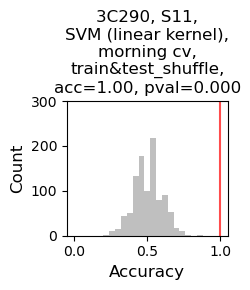

In [81]:
plt.figure(figsize=(2.5,3))  
bin_edges = np.arange(0, 1+0.04, 0.04)
plt.hist(acc_sh_me, bins=bin_edges, alpha=0.5, color='gray')
plt.axvline(acc_svm_me,color='red', alpha=0.7)
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0.0,0.5,1.0])  
plt.ylim(0,300)
plt.title(f'{mouse}, S{Session},\nSVM (linear kernel),\nmorning cv,\ntrain&test_shuffle,\nacc={acc_svm_me:.2f}, pval={p_value_me:.3f}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_SVM_me.png', dpi=300, bbox_inches='tight')
plt.show()

In [82]:
classifiers_results = {'accuracy_svm':accuracy_svm, 
                       'p_value_ab':p_value_ab,
                       'acc_svm_m':acc_svm_m,
                       'p_value_m':p_value_m,
                       'acc_svm_me':acc_svm_me,
                       'p_value_me':p_value_me}

# # evening
# accuracy_svm
# p_value_ab

# # morning
# acc_svm_m
# p_value_m

# # morning vs evening
# acc_svm_me
# p_value_me

In [83]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_evening\\{mouse}_S{Session}_classifiers_results.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(classifiers_results, f)

In [49]:
# # load
# with open(save_path, 'rb') as f:
#     classifiers_results = pickle.load(f)
# classifiers_results